In [12]:
import json
import os
from torch.utils.data import Dataset, random_split, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import matplotlib.pyplot as plt

## Config

In [13]:
# train params
train_size = 0.8
val_size = 0.1
test_size = 0.1
batch_size = 16
learning_rate = 0.001
epochs = 10

# TODO add more joints => adjust input channels, flatten the data
choosen_joints = ["RAnkle_x"]

# labels
LABELS = {
    "unknown": 0,
    "gear2" : 1,
    "gear3" : 2,
    "gear4" : 3,
}

# file config
files = ["09", "14_cut", "15_cut", "17_cut", "18_cut", "22_cut", "25", "38", "40", "43", "44", "54_cut"]
file_name = "labeled_cycles_"
path = "../cycle_splits"

TODO create cycle plot?!

In [14]:
# half ChatPGT generated
class CustomDataset(Dataset):
    
    def __init__(self, 
                 files, 
                 path, 
                 file_name="labeled_cycles_", 
                 choosen_joints=["RAnkle_x"],
                 label_dict = {
                    "unknown": 0,
                    "gear2" : 1,
                    "gear3" : 2,
                    "gear4" : 3,},
                 transform=None,
                 target_transform=None, 
                 padding_value=0.0):
        
        self.label_dict = label_dict
        self.choosen_joints = choosen_joints
        self.padding_value = padding_value
        self.data, self.labels = self.__load_data(files, file_name, path)
        self.transform = transform
        self.target_transform = target_transform

    def __load_data(self, files, file_name, path):
        data = []
        labels = []
        longest_cycle = 0  # Track longest cycle length

        for file in files:
            file_path = os.path.join(path, file_name + file + ".json")
            with open(file_path, 'r') as f:
                data_json = json.load(f)

            for cycle in data_json.values():
                # Extract joint data as (num_joints, time_steps)
                cycle_data = [torch.tensor(cycle[joint], dtype=torch.float32) for joint in self.choosen_joints]

                # Stack into a (num_joints, time_steps) tensor
                cycle_tensor = torch.stack(cycle_data)  # Shape: (num_joints, time_steps)
                longest_cycle = max(longest_cycle, cycle_tensor.shape[1])  # Update max length

                data.append(cycle_tensor)
                labels.append(cycle["Label"])

        # Pad all cycles to match the longest cycle length
        padded_data = []
        for cycle in data:
            num_joints, time_steps = cycle.shape

            # Pad the time_steps dimension
            pad_length = longest_cycle - time_steps
            padded_cycle = torch.nn.functional.pad(cycle, (0, pad_length), value=self.padding_value)  # Pad last dim

            padded_data.append(padded_cycle)

        # Stack all padded cycles into a final tensor
        padded_data = torch.stack(padded_data)  # Shape: (num_cycles, num_joints, max_time)

        return padded_data, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        label = self.label_dict[self.labels[idx]]
        item = self.data[idx]
        
        if self.transform:
            item = self.transform(item)

        if self.target_transform:
            label = self.target_transform(label)

        return item, label


In [15]:
# create custom dataset
dataset = CustomDataset(files, path, file_name, choosen_joints)

# split data into train, val and test set
generator1 = torch.Generator().manual_seed(42)
train_split = int(dataset.__len__() * 0.8)
val_split = int(dataset.__len__() * 0.1)
test_split = int(dataset.__len__() - train_split - val_split)

print(f"Train size = {train_split}, Val size = {val_split}, Test size =  {test_split}")

train_data, val_data, test_data = random_split(dataset, [train_split, val_split, test_split], generator=generator1)

# create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Train size = 121, Val size = 15, Test size =  16


In [16]:
class Net(nn.Module):

    def __init__(self, input_channels, hidden1, hidden2, output):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(input_channels, hidden1)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(hidden1, hidden2)
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden2, output)

    def forward(self, input):
        
        out = self.activation(self.linear1(input))
        out = self.activation2(self.linear2(out))
        out = self.output_layer(out)
        
        return out 

In [17]:
input_channels = len(dataset[0][0][0]) # get first entry, then item and then first joint
hidden1 = 128
hidden2 = 64
output = len(set(dataset.labels))

net = Net(input_channels=input_channels, hidden1=hidden1, hidden2=hidden2, output=output)
print(net)

Net(
  (linear1): Linear(in_features=97, out_features=128, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (activation2): ReLU()
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)


## Training the Neural Net

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

TODO
    - add validation
    - add accuracy
    - add other metrics
    - add plots
    - add epoch and batch loss?!
    - add GPU support

In [19]:
print(len(train_loader))

8


In [20]:
def training(train_loader, net, criterion, optimizer):
    
    running_loss = 0.0
    epoch_accuracy = 0.0
    total_samples = 0  # To track the number of samples for accuracy calculation
    correct_predictions = 0  # To track the correct predictions
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # Add loss for this batch to the total loss
        total_samples += labels.size(0)  # Increment total samples
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
        correct_predictions += (predicted == labels).sum().item()  # Increment correct predictions

    # Calculate the average loss for the epoch
    avg_epoch_loss = running_loss / len(train_loader)  # Average loss per batch
    running_accuracy = 100 * correct_predictions / total_samples  # Calculate accuracy as a percentage

    return avg_epoch_loss, running_accuracy 

def validation(val_loader, net, criterion):
    running_val_loss = 0.0
    epoch_accuracy = 0.0
    total_samples = 0  # To track the number of samples for accuracy calculation
    correct_predictions = 0  # To track the correct predictions
    
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = net(inputs)
            outputs = outputs.squeeze(1)
            val_loss = criterion(outputs, labels)
            
            # accumulate validation loss
            running_val_loss += val_loss.item()
            total_samples += labels.size(0)  # Increment total samples
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            correct_predictions += (predicted == labels).sum().item()  # Increment correct predictions
            
        # Calculate the average validation loss over all batches
        avg_val_loss = running_val_loss / len(val_loader)  # len(val_loader) is the number of batches
        epoch_accuracy = 100 * correct_predictions / total_samples  # Calculate accuracy as a percentage
    
    return avg_val_loss, epoch_accuracy   


In [21]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):  # loop over the dataset multiple times
    
    print("Training")
    epoch_loss, epoch_acc = training(train_loader, net, criterion, optimizer)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.3f}")
    
    print("Validation")
    epoch_val_loss, epoch_val_acc = validation(val_loader, net, criterion)
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_val_loss:.3f}, Accuracy: {epoch_val_acc:.3f}")
    
print('Finished Training')

Training
Epoch: 1/10, Loss: 0.778, Accuracy: 77.686
Validation
Epoch: 1/10, Loss: 0.573, Accuracy: 86.667
Training
Epoch: 2/10, Loss: 0.200, Accuracy: 92.562
Validation
Epoch: 2/10, Loss: 0.453, Accuracy: 80.000
Training
Epoch: 3/10, Loss: 0.129, Accuracy: 96.694
Validation
Epoch: 3/10, Loss: 0.485, Accuracy: 80.000
Training
Epoch: 4/10, Loss: 0.084, Accuracy: 97.521
Validation
Epoch: 4/10, Loss: 0.514, Accuracy: 80.000
Training
Epoch: 5/10, Loss: 0.043, Accuracy: 99.174
Validation
Epoch: 5/10, Loss: 0.397, Accuracy: 80.000
Training
Epoch: 6/10, Loss: 0.028, Accuracy: 100.000
Validation
Epoch: 6/10, Loss: 0.550, Accuracy: 80.000
Training
Epoch: 7/10, Loss: 0.022, Accuracy: 100.000
Validation
Epoch: 7/10, Loss: 0.688, Accuracy: 80.000
Training
Epoch: 8/10, Loss: 0.017, Accuracy: 100.000
Validation
Epoch: 8/10, Loss: 0.671, Accuracy: 80.000
Training
Epoch: 9/10, Loss: 0.011, Accuracy: 100.000
Validation
Epoch: 9/10, Loss: 0.672, Accuracy: 80.000
Training
Epoch: 10/10, Loss: 0.008, Accura

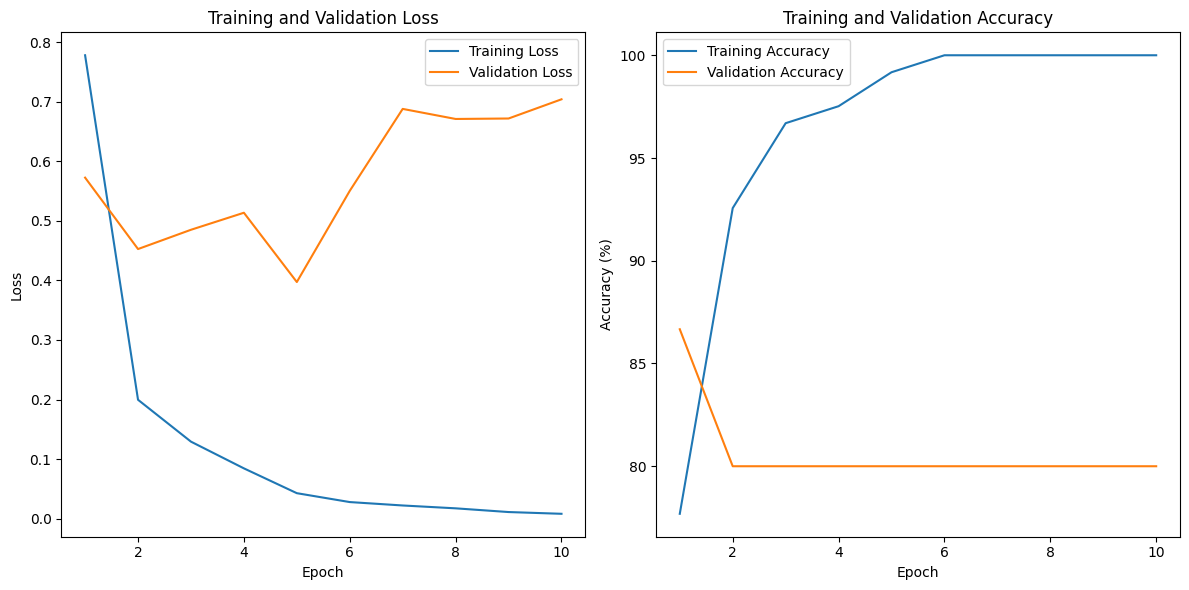

In [22]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()